# Zmienne kategoryczne w sklearn + szybki ogląd danych

Sci-kit learn w obecnej wersji wymaga, aby ramka dostarczana do metody `.fit` zawierała *tylko* wartości  numeryczne (kolumny boolowe zostaną zrzutowane do wartości `[1, 0]`). Oczekuje się więc od użytkownika, że cechy zawierające typ `string`, czy `datetime` zostaną zakodowane tak, aby klasyfikator mógł wyekstrahować informację zawartą w danych. Ale **UWAGA:** nie możemy z góry założyć, że jeśli kolumna zawiera wartość numeryczną (w szczególności: `int`), to że automatycznie nie jest nominalna.

Zaczniemy od przejrzenia wartości w poszczególnych kolumnach naszych danych treningowych. Chcemy znaleźć cechy nominalne (kategoryczne), które następnie pogrupujemy ze względu na typ, liczbę unikatowych wartości, oraz inne kryteria.

In [3]:
import numpy as np
import pandas as pd

In [4]:
x_and_y_train = pd.concat([pd.read_csv('data/xtrain_1.csv'),
                           pd.read_csv('data/xtrain_2.csv'),
                           pd.read_csv('data/y_train.csv', header=None, names=['y'])],
                          axis=1)

x_and_y_train['received_at'] = pd.to_datetime(x_and_y_train['received_at'])

x_and_y_train = x_and_y_train.sort_values('received_at')

ytrain = x_and_y_train.pop('y')
xtrain = x_and_y_train

/home/md/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,3,11,16,23,90,92,95,102,141,151,185,191) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
for colname in sorted(xtrain.columns):
    not_nones = xtrain[colname][pd.notnull(xtrain[colname])]
    has_complex_types = any(not_nones.apply(lambda x: isinstance(x, (dict, list))))
    is_not_Series = not isinstance(not_nones, pd.Series)
    if has_complex_types or is_not_Series:
        continue
    unique_values = not_nones.unique()
    print('{} ({}): {}'.format(colname, len(unique_values), unique_values[:10]))

agent_type (2): ['browser_mobile' 'browser_computer']
api_call_datetime (0): []
application_id (2): [40 43]
bin (3695): [434769 533248 418646 545958 527267 472409 456534 532737 421402 516361]
bin_country (142): ['GB' 'SE' 'CA' 'DK' 'PT' 'AU' 'MT' 'US' 'BR' 'MA']
browser (8): ['Chrome' 'Firefox' 'Safari' 'Internet Explorer' 'Opera' 'Other' 'Unknown'
 'Edge']
browser_language (839): ['en-US' 'en-US,en;q=0.8' 'fr-FR,fr;q=0.8,en-US;q=0.6,en;q=0.4'
 'en-US,en;q=0.5' 'en-CA,en-GB;q=0.8,en-US;q=0.6,en;q=0.4' 'en-au'
 'fr-CA,fr;q=0.8,en-US;q=0.6,en;q=0.4' 'sv-se' 'en-us'
 'en-GB,en-US;q=0.8,en;q=0.6']
browser_string (5563): [ 'Mozilla/5.0 (Linux; Android 6.0.1; Nexus 6 Build/MMB29S; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/47.0.2526.100 Mobile Safari/537.36'
 'Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/48.0.2564.97 Safari/537.36'
 'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/48.0.2564.97 Safari/53

In [6]:
low_card_cat_colnames = [
                    'agent_type', 'bin_country', 'browser', 'browser_string_mismatch',
                    'card_brand', 'card_level', 'card_type', 'cc_bin_number_brand', 'cc_bin_number_type',
                    'cc_number_hash_assert_history', 'cc_number_hash_result', 'input_ip_assert_history',
                    'input_ip_geo', 'input_ip_result', 'js_browser', 'js_fonts_number', 'js_os', 'navigatorplatform',
                    'os', 'remote_desktop', 'request_result', 'review_status', 'x10047', 'x12050', 'x16453', 
                    'x21202', 'x21215', 'x21877', 'x26431', 'x32520', 'x39150', 'x41009', 'x5170', 'x5193',
                    'x5290', 'x5342', 'x55586', 'x66439', 'x70617', 'x72496', 'x73629', 'x80025', 'x80385',
                    'x80911', 'x83032', 'x83336', 'x91746', 'x92645', 'x96255', 
                   ]
                    
                    
high_card_cat_colnames = [
                    'bin', 'browser_string_hash', 'cc_bin_number', 'cc_bin_number_category', 'cc_bin_number_geo',
                    'cc_bin_number_org', 'country_code', 'dns_ip_city', 'dns_ip_isp', 'dns_ip_organization',
                    'dns_ip_region', 'input_ip_city', 'js_browser_string_hash', 'js_fonts_hash', 'language',
                    'mime_type_hash', 'name', 'user_ip_country', 'x12964', 'x18591', 'x2801', 'x30901', 'x33709',
                    'x46567', 'x46591', 'x52094', 'x55037', 'x61305', 'x63143', 'x66015', 'x76585', 'x82598',
                    'x87611', 'x92166', 'x92221', 'x94347', 
                    ]
                    
parsable_cat_colnames = [
                    'browser_string', 'headers_accept_encoding', 'headers_accept_language', 'headers_user_agent',
                    'input_ip_attributes', 'js_browser_string', 'navigatorappversion', 'useragent', 'x31255',
                    'x50315', 
                    ]
                    
degree_cat_colnames = ['risk_rating']
                    
castable_to_numeric_cat_colnames = [
                    'x23739', 'x3314', 'x42317', 'x43300', 'x44170', 'x48420', 'x51274', 'x54084',
                    'x5600', 'x59752', 'x60781', 'x87918', 'x9486', 'x97674', 'x98509',
                    'application_id'
                    ]

# Modele budowane na zmiennych kategorycznych

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeClassifier
from sklearn.preprocessing import Imputer

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
%matplotlib inline

import category_encoders as ce

from hash_transformers import SimplisticHasher

/home/md/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Modele budowane na `low_card_cat_colnames`

In [8]:
DF_cat = xtrain[low_card_cat_colnames]
DF_cat.head()

,agent_type,bin_country,browser,browser_string_mismatch,card_brand,card_level,card_type,cc_bin_number_brand,cc_bin_number_type,cc_number_hash_assert_history,...,x72496,x73629,x80025,x80385,x80911,x83032,x83336,x91746,x92645,x96255
0,browser_mobile,NaN,NaN,NaN,VISA,CLASSIC,debit,VISA,DEBIT,NaN,...,NaN,NaN,NaN,yes,new_device,default,success,success,NaN,not found
1,browser_computer,NaN,NaN,NaN,MASTERCARD,PREPAID,debit,MASTERCARD,DEBIT,NaN,...,NaN,NaN,NaN,yes,new_device,default,not found,success,NaN,not found
2,browser_computer,NaN,NaN,NaN,VISA,CLASSIC,debit,VISA,DEBIT,NaN,...,NaN,NaN,NaN,yes,success,default,success,success,NaN,success
3,browser_computer,NaN,NaN,NaN,MASTERCARD,STANDARD,debit,MASTERCARD,DEBIT,NaN,...,NaN,NaN,NaN,yes,success,default,not found,success,NaN,success
4,browser_computer,NaN,NaN,NaN,MASTERCARD,STANDARD,NaN,MASTERCARD,CREDIT,NaN,...,NaN,NaN,NaN,yes,new_device,default,success,success,NaN,not found


**WAŻNA UWAGA:** zwróćcie uwagę, że metoda podziału na treningowy/walidacyjny używana poniżej (`TimeSeriesSplit`) **zakłada**, że ramka jest posortowana wg odpowiedniej kolumny czasowej (tutaj: `received_at`).

/home/md/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2440: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


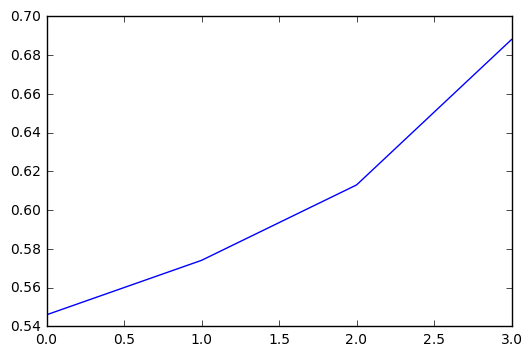

In [15]:
cat_colnames = DF_cat.columns.tolist()

pipe = Pipeline([
#     ('hashing_trick', ce.HashingEncoder(cols=cat_colnames, n_components=10*len(cat_colnames))),
    ('simplistic_hash', SimplisticHasher(cols=cat_colnames)),
    
    ('imputer', Imputer(missing_values=pd.np.nan, strategy='most_frequent', axis=0)),    
#     ('xgb', XGBClassifier()),
    ('log_reg', LogisticRegression()),
#     ('lin_reg', LinearRegression()),
#     ('ridge', RidgeClassifier()),
])


scores = cross_val_score(pipe,
                         DF_cat,
                         ytrain,
                         scoring='roc_auc',
                         cv=TimeSeriesSplit(6))

plt.plot(scores)

## Modele budowane na `[low_card_cat_colnames, high_card_cat_colnames]`

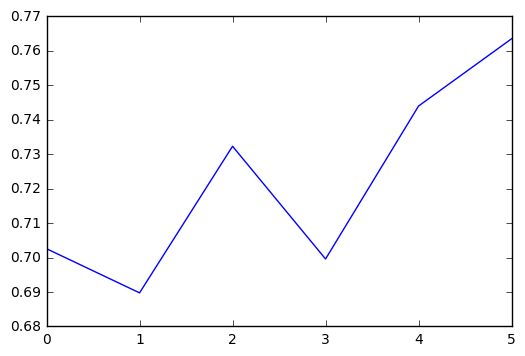

In [16]:
DF_cat = xtrain[low_card_cat_colnames+high_card_cat_colnames]

cat_colnames = DF_cat.columns.tolist()

pipe = Pipeline([
    ('hashing_trick', ce.HashingEncoder(cols=cat_colnames, n_components=10*len(cat_colnames))),
#     ('simplistic_hash', SimplisticHasher(cols=cat_colnames)),
    
#     ('imputer', Imputer(missing_values=pd.np.nan, strategy='most_frequent', axis=0)),    
    ('xgb', XGBClassifier()),
#     ('log_reg', LogisticRegression()),
#     ('lin_reg', LinearRegression()),
#     ('ridge', RidgeClassifier()),
])


scores = cross_val_score(pipe,
                         DF_cat,
                         ytrain,
                         scoring='roc_auc',
                         cv=TimeSeriesSplit(6))

plt.plot(scores)

# Kolumny zawierające słowniki

In [11]:
def undict_one_col(df, colname):
    column = df.pop(colname)
    values = [dict() if x is None else x for x in column]
    unpacked_columns = pd.DataFrame.from_dict(values)
    unpacked_columns = unpacked_columns.add_prefix(colname + '_')
    return pd.concat([df, unpacked_columns], axis=1)

def undict_cols(df, col_names):
    for col_name in col_names:
        df = undict_one_col(df, col_name)    
    return df


dict_counts = xtrain.apply(lambda col: col.apply(lambda x: isinstance(x, dict))).sum()
dict_colnames = dict_counts[dict_counts>0].index.tolist()

xtrain_undicted = undict_cols(xtrain[dict_colnames], dict_colnames)
xtrain_undicted_numeric = xtrain_undicted.select_dtypes(include=[np.number])

## Model zbudowany na zmiennych kategorycznych + numerycznych ze słowników

In [12]:
DF_cat_and_undict = pd.concat([DF_cat, xtrain_undicted_numeric], axis=1)
cat_colnames = DF_cat_and_undict.select_dtypes(exclude=[np.number]).columns.tolist()

DF_cat_and_undict.head()

,agent_type,bin_country,browser,browser_string_mismatch,card_brand,card_level,card_type,cc_bin_number_brand,cc_bin_number_type,cc_number_hash_assert_history,...,x55037,x61305,x63143,x66015,x76585,x82598,x87611,x92166,x92221,x94347
0,browser_mobile,NaN,NaN,NaN,VISA,CLASSIC,debit,VISA,DEBIT,NaN,...,android 4.0,NaN,NaN,NaN,US,NaN,android browser 4.0,NaN,NaN,NaN
1,browser_computer,NaN,NaN,NaN,MASTERCARD,PREPAID,debit,MASTERCARD,DEBIT,NaN,...,chrome 48.0,NaN,NaN,NaN,US,"WIN 20,0,0,286",chrome 48.0,NaN,NaN,Windows 8
2,browser_computer,NaN,NaN,NaN,VISA,CLASSIC,debit,VISA,DEBIT,NaN,...,chrome 48.0,NaN,NaN,NaN,US,"WIN 20,0,0,286",chrome 48.0,NaN,NaN,Windows 8.1
3,browser_computer,NaN,NaN,NaN,MASTERCARD,STANDARD,debit,MASTERCARD,DEBIT,NaN,...,chrome 47.0,NaN,NaN,NaN,US,"WIN 20,0,0,286",chrome 47.0,NaN,NaN,Windows 8.1
4,browser_computer,NaN,NaN,NaN,MASTERCARD,STANDARD,NaN,MASTERCARD,CREDIT,NaN,...,chrome 48.0,NaN,NaN,NaN,US,"WIN 20,0,0,286",chrome 48.0,NaN,NaN,Windows 10


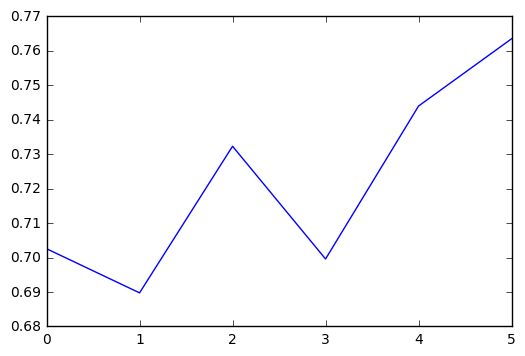

In [18]:
scores = cross_val_score(pipe,
                         DF_cat_and_undict,
                         ytrain,
                         scoring='roc_auc',
                         cv=TimeSeriesSplit(6))

plt.plot(scores)

# Odnośniki

#### One Hot Encoding i algorytmy drzewiaste
Post: http://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/ omawia przykład, w którym kodowanie zmiennych nominalnych przy użyciu OHE porównywane jest z kodowaniem wykorzystywanym domyślnie w bibliotece H2O (http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/nbins_cats.html). Dodatkowo: paragraf *4.6 Treatment of factors* w opisie GBMów w H2O https://h2o-release.s3.amazonaws.com/h2o/master/3153/docs-website/h2o-docs/booklets/GBM_Vignette.pdf



#### Wykład Owena Zhanga
https://www.youtube.com/watch?v=LgLcfZjNF44, w którym mowa o: GBMach, kodowaniu zmiennych nominalnych, licznych "sztuczkach" przydatnych w konkursach kaggle'owych. 



#### GBMy w ramach Distributed Machine Learning Toolkit
https://github.com/Microsoft/LightGBM; w swoim benchmarku autorzy twierdzą, LightGBM daje w niektórych przypadkach lepsze wyniki, niż XGBoost (https://github.com/Microsoft/LightGBM/wiki/Experiments#comparison-experiment).



#### Pull request na repo sklearnowym odn. wprowadzenia natywnego wsparcia dla zmiennych kategorycznych
https://github.com/scikit-learn/scikit-learn/pull/4899



#### Repo paczki `category_encoders`
https://github.com/scikit-learn-contrib/categorical-encoding

# Praca domowa
(do wykonania grupowo)

0. Zbierzcie powielone kawałki kodu z tego notatnika i opakujcie je w funkcje, które będą w plikach `.py` (tak, żeby można je było importować);

1. Przejrzyjcie pozostałe typy zmiennych kategorycznych (`parsable_cat_colnames, degree_cat_colnames, castable_to_numeric_cat_colnames`) i wybierzcie te, które chcecie jeszcze dodać do danych treningowych;

2. Rozpakujcie kolumny zawierające wartości typu `list` (polecam szczególnie kolumnę `'flash_fonts'`);

3. Wypróbujcie inne klasyfikatory (`sklearn.ensemble.AdaBoostClassifier`, `sklearn.svm.SVC`);


# Przypomnienie

Jeśli chcecie popracować na AWSie w domu, ustalcie jaki termin by Wam najbardziej pasował i dajcie znać na maila: **maciej.dziubinski@daftcode.pl**